<a href="https://colab.research.google.com/github/vvshyer/tensorflow2.0_learning/blob/master/embedding_lstm_subword.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 71kB/s 
     |████████████████████████████████| 501kB 54.4MB/s 
     |████████████████████████████████| 3.1MB 52.3MB/s 
  Found existing installation: tf-estimator-nightly 1.14.0.dev2019030115
    Uninstalling tf-estimator-nightly-1.14.0.dev2019030115:
      Successfully uninstalled tf-estimator-nightly-1.14.0.dev2019030115
  Found existing installation: tb-nightly 1.14.0a20190301
    Uninstalling tb-nightly-1.14.0a20190301:
      Successfully uninstalled tb-nightly-1.14.0a20190301
  Found existing installation: tensorflow-gpu 2.0.0a0
    Uninstalling tensorflow-gpu-2.0.0a0:
      Successfully uninstalled tensorflow-gpu-2.0.0a0


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.3
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [18]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('imdb_reviews/subwords8k',
                          with_info = True,
                          as_supervised = True)

train_dataset, test_dataset = dataset['train'], dataset['test']

W0804 07:37:30.739910 140655183710080 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [19]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts

In [20]:
tokenizer = info.features['text'].encoder
print('vocabulary size: {}'.format(tokenizer.vocab_size))

vocabulary size: 8185


In [21]:
sample_string = "Tensorflow is cool."
tokenized_string = tokenizer.encode(sample_string)
print("tokenized string is {}".format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print("original string is {}".format(original_string))


tokenized string is [6307, 2327, 2934, 7961, 9, 2724, 7975]
original string is Tensorflow is cool.


In [22]:
for token in tokenized_string:
    print('{} --> "{}"'.format(token, tokenizer.decode([token])))

6307 --> "Ten"
2327 --> "sor"
2934 --> "flow"
7961 --> " "
9 --> "is "
2724 --> "cool"
7975 --> "."


In [23]:
# shuffle, batch
buffer_size = 10000
batch_size = 64

train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.padded_batch(
    batch_size, train_dataset.output_shapes)
test_dataset = test_dataset.padded_batch(
    batch_size, test_dataset.output_shapes)

print(train_dataset.output_shapes)
print(test_dataset.output_shapes)

(TensorShape([None, None]), TensorShape([None]))
(TensorShape([None, None]), TensorShape([None]))


In [24]:
embedding_dim = 16
batch_size = 512

vocab_size = tokenizer.vocab_size

bi_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=32, return_sequences=False)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
bi_rnn_model.summary()

bi_rnn_model.compile(optimizer='adam', 
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 145,617
Trainable params: 145,617
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = bi_rnn_model.fit(
    train_dataset,
    epochs = 10,
    validation_data = test_dataset)

Epoch 1/10


W0804 07:37:51.694646 140655183710080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


391/391 [==============================] - 291s 744ms/step - loss: 0.5910 - accuracy: 0.6684 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 113s 288ms/step - loss: 0.3772 - accuracy: 0.8408 - val_loss: 0.4264 - val_accuracy: 0.8108
Epoch 3/10
391/391 [==============================] - 84s 215ms/step - loss: 0.3142 - accuracy: 0.8749 - val_loss: 0.5043 - val_accuracy: 0.7555
Epoch 4/10
391/391 [==============================] - 70s 178ms/step - loss: 0.2776 - accuracy: 0.8948 - val_loss: 0.4094 - val_accuracy: 0.8376
Epoch 5/10
391/391 [==============================] - 69s 178ms/step - loss: 0.3020 - accuracy: 0.8699 - val_loss: 0.5903 - val_accuracy: 0.6762
Epoch 6/10
391/391 [==============================] - 67s 172ms/step - loss: 0.2549 - accuracy: 0.8983 - val_loss: 0.4615 - val_accuracy: 0.8098
Epoch 7/10
391/391 [==============================] - 65s 165ms/step - loss: 0.3978 - accuracy: 0.8269 - val_loss: 0.5116 - val_acc

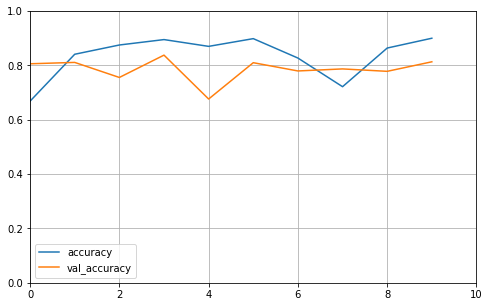

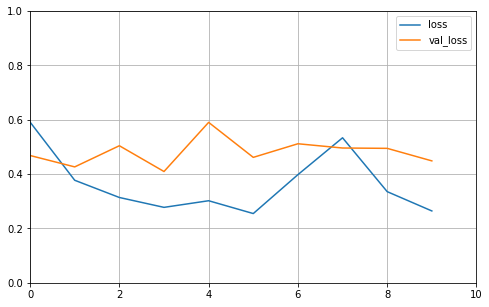

In [29]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
epochs = 10
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 1)

In [28]:
bi_rnn_model.evaluate(test_dataset)

    391/Unknown - 19s 48ms/step - loss: 0.4486 - accuracy: 0.8131

[0.44856845029174824, 0.81312]